### Intuition behind this approach:
* There can be an alternate way to capture more information for representing each name as a vector
* Each name is made of letters
* Combination of letters that occur together in words are specific to that language
* Using this "context" of such letter combinations can result in better evaluation of features for a name
* Here, I will create tokens of size 't' and take 'n' Grams to catch the context of each token
* Then Word2Vec [https://arxiv.org/abs/1301.3781] is used to create vectors for each token
* For each name, it can be broken down to its own tokens and use the above Word2Vec vector to represent the name
* I shall be using averaging to create feature space of names from its token Vectors

In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_table('hindu_baby_names.txt',sep='\n',names=['Names'])

In [3]:
data.head()

,Names
0,aabha
1,aabharan
2,aabheer
3,aachman
4,or puja


### Checking for Null values

In [4]:
data['Names'].isnull().values.any()

False

In [5]:
data=data['Names'].str.lower()

### Check if any rows have duplicate values

In [6]:
rows=data.duplicated(keep='first')
rows.value_counts()

False    7299
True      891
Name: Names, dtype: int64

* We have a total of 428 names which are duplicates.
* keep='first' keeps the first value as False and marks the rest of the duplicates as True

In [7]:
dataCopy=data.copy()

### Split data in training and testing
    

In [8]:
#Split Size is the percentage of data in training set
def splitData(dataCopy,splitSize):
    trainData=[]
    testData=[]
    trainNames=dataCopy[:int(.01*splitSize*len(dataCopy))]
    testNames=dataCopy[len(trainNames):]

    for i in range(len(trainNames)):
        trainData.append(trainNames.iloc[i])
    for i in range(len(testNames)):
        testData.append(testNames.iloc[i])
        
    print("Number of names in training Set: "+str(len(trainData)))
    print("Number of names in test Set: "+str(len(testData)))
    return trainData,testData

In [9]:
trainNames,testNames=splitData(dataCopy,95)

Number of names in training Set: 7780
Number of names in test Set: 410


### Creating corpus of the names


* Will remove all words occuring separately (i.e separated by space from real names)
* Also remove the punctuations present in the names

In [10]:
def removeNoisyWords(text):
    stopList=set('or a the and it is if to in for of'.split())
    result=[]
    for name in text:
        words=name.lower().split()
        temp=[]
        for i in words:
            if i not in stopList:
                temp.extend(i)
        result.append(temp)   
    return result

In [11]:
def cleanText(t):
    return ''.join(l.strip(',."!?;:()/\'') for l in t)

In [12]:
trainNames[:5]

['aabha', 'aabharan', 'aabheer', 'aachman', 'or puja']

In [13]:
trainNames=removeNoisyWords(trainNames)
trainNames=[cleanText(n) for n in trainNames]

In [14]:
trainNames[:5]

['aabha', 'aabharan', 'aabheer', 'aachman', 'puja']

* for example: or is removed from puja which was present earlier

In [15]:
totalNames=trainNames+testNames

### Creating tokens by taking 'n' tokens of 't' letters at a time

In [16]:
def createNGramsFromCorpus(corpus,t,n):
    nGramData=[]
    for i in corpus:
        tokenized=generateTokens(i,t)
        ngram=generateNgrams(tokenized,n)
        nGramData.extend(ngram)
    return nGramData

def generateTokens(text,n):
    letters=text
    output=[]
    for i in range(len(letters)-n+1):
        output.append(letters[i:i+n])
    return output

def generateNgrams(tokens,n):
    output=[]
    for i in range(len(tokens)-n+1):
        output.append(tokens[i:i+n])
    return output

In [17]:
class text:
    def __init__(self,data,tokenSize,nGram):
        self.data=createNGramsFromCorpus(data,tokenSize,nGram)
        self.tokenSize=tokenSize
        self.nGram=nGram

### Generate Embeddings of each token

* Using Gensim Library to create Word2Vec representation of tokens
* Link (Gensim) : https://radimrehurek.com/gensim/

In [18]:
from gensim.models import Word2Vec

C:\Users\Siddharth\Anaconda3\envs\tensorflow-gpu\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [19]:
def formWord2Vec(data,size=100,window=5):
    return Word2Vec(data,size,window)

* The above function takes in the data
* This data is a list of lists of tokens taken n tokens together to catch the context 

### Visualize the word embedding

* A 2-dimensional representation using PCA dimensionality reduction
* This must not be taken to word but it does gives a slight intuition to see how token lie on the vector space

In [20]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline

In [21]:
def visualizePCA(model):
    #using 2 components for PCA to visualize in 2 dimension
    pca=PCA(n_components=2)
    result=pca.fit_transform(model[model.wv.vocab])
    plt.scatter(result[:,0],result[:,1],alpha=.2)
    letters=list(model.wv.vocab)
    for i in range(0,len(letters)):
        letter=letters[i]
        plt.annotate(letter,xy=(result[i,0],result[i,1]))
    plt.title("Model 2-d Visualization")
    plt.show()

In [22]:
def visualizePCA1(df,names):
    #using 2 components for PCA to visualize in 2 dimension
    pca=PCA(n_components=2)
    result=pca.fit_transform(df)
    plt.scatter(result[:,0],result[:,1],alpha=.2)
    for i in range(0,len(names),100):
        name=names[i]
        plt.annotate(name,xy=(result[i,0],result[i,1]))
    plt.title("Model 2-d Visualization")
    plt.show()

### Create dictionary of words to vectors

* This dictionary will be a mapping of token to its vector representation

In [23]:
def generateMapping(m):
    w2v={l:vec for l,vec in zip(m.wv.index2word,m.wv.vectors)}
    return w2v

### Get Mean of Vectors of tokens in a name to represent names as vectors

* This is just a basic method, that first came to my mind.
* Intuition is that the mean of each token in the name will give us a way to represent the name as a vector

In [24]:
def getMean(text,d,tokenSize):
    letters=d.keys()
    dim=len(d[next(iter(letters))])
    #print(dim)
    text=generateTokens(text,tokenSize)
    #print(text)
    
    mean=np.mean([d[l] for l in text if l in d]
                or [np.zeros(dim)],axis=0)
    return np.array(mean)

def getVectorsOfNames(tokenSize,text,d):
    newText=[]
    for name in text:
        name=name.lower()
        mean=getMean(name,d,tokenSize)
        newText.append([name,mean])
    return pd.DataFrame(newText)

def getFeatureSet(textDF):
    rowList=[]
    for i in range(len(textDF)):
        row=textDF.iloc[i][1]
        rowList.append(row)
    featureSet=pd.DataFrame(rowList)
    return featureSet

* These functions will return a DataFrame which will represent the feature set of all the names in the text passed. 
* Each name is represented by 100 features as each token had 100 features from word2Vec model

### One Class SVM Model

* OneClassSVM is a boundary method
* It assumes a hypersphere around the target class

In [25]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

In [26]:
#train Model for one class classificatio
def trainModelOCC(model,X,y):
    model.fit(X,y)  
    return model

def predict(model,names,d,tokenSize): 
    #print(names)
    vec=getVectorsOfNames(tokenSize,names,d)
    vec=getFeatureSet(vec)
    #print(vec)
    return model.predict(vec)

### Plot Learning Curve

* This graph plots the learning curve 
* Plots Training and Validation Curve on the training data 
* Can be used to infer bias and variance 
* Can also be used to infer if more data is required for the training

In [27]:
def plotLearningCurve(estimator,title,X,y,n_jobs=1,scoring="accuracy"):
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel(scoring)
    train_sizes,train_scores,test_scores=learning_curve(estimator,
                                                    X,y,
                                                   n_jobs=2,scoring="accuracy")
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,
                    train_scores_mean+train_scores_std,alpha=0.1,color='g')
    
    plt.fill_between(train_sizes,test_scores_mean-test_scores_std,
                    test_scores_mean+test_scores_std,alpha=0.1,color='r')
    plt.plot(train_sizes,train_scores_mean,'o-',color='g',label="Training Score")
    plt.plot(train_sizes,test_scores_mean,'o-',color='r',label="Cross Validation Score")
    plt.legend(loc="best")
    return plt

### Get the text from the negative Classes

* The following lines bring together the names form the negative_class files
* Some percentage of target class is also attached to create a typical unseen test set

In [28]:
df1=pd.read_table('negative_class_1.txt',sep='\n',names=['Names'])
df2=pd.read_table('negative_class_2.txt',sep='\n',names=['Names'])
df1=df1.append(df2,ignore_index=True)
testFilesCorpus=[]
for i in range(len(df1)):
    word=df1.iloc[i]
    testFilesCorpus.extend(word)

### Trying out tokenSize=2 and 2gram approach

#### Model intuition:
* Trying out tokens of size two and 2gram 
* I think to capture the intricacies of a language, the essence lies in the context of a token too.
i.e: for a name "aditya" (I know hindi so have a bit of learning already present in the model :P),
    the context of it is di, ty and this is unique to this language

In [29]:
#Create Text Class object using 2as token size and 2 as ngram parameter
twoT2GramObj=text(trainNames,2,2)
twoT2GramObj.data[:5]

[['aa', 'ab'], ['ab', 'bh'], ['bh', 'ha'], ['aa', 'ab'], ['ab', 'bh']]

In [30]:
#Get the word2Vec model of tokens and generate the mapping dictionary
twoT2GramModel=formWord2Vec(twoT2GramObj.data,100,5)
token2Vec2Gram=generateMapping(twoT2GramModel)
newText=getVectorsOfNames(twoT2GramObj.tokenSize,trainNames,token2Vec2Gram)
newText.head()

,0,1
0,aabha,"[10.0508, -49.6078, 7.72161, 39.583, -21.3384,..."
1,aabharan,"[3.41646, -30.8064, 7.09217, 21.268, -10.146, ..."
2,aabheer,"[10.3983, -23.3914, -3.25525, -2.96071, -11.97..."
3,aachman,"[-5.68943, 2.66237, 2.67407, -3.03496, 4.52307..."
4,puja,"[0.321058, 3.53594, -1.59582, 0.287695, 0.6121..."


In [31]:
twoT2GramVectors=twoT2GramModel.wv.vectors
len(twoT2GramVectors[0])

100

C:\Users\Siddharth\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


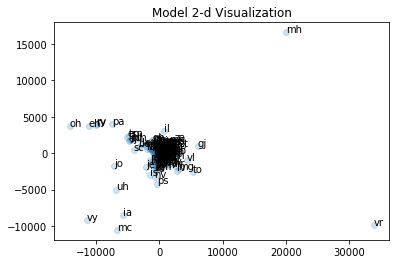

In [32]:
visualizePCA(twoT2GramModel)

* This gives a slight idea as to which token are most dissimilar
* for example token 'ov', 'ry', 'mv' are quite not similar to other tokens in the corpus
* While there are major tokens which are quite close to each other as seen by this vector representation

In [33]:
#Get the Feature Set of the trainNames in the twoT2GramModel
twoT2GramTextFS=getFeatureSet(newText)
y=[1 for _ in range(len(newText))]
print("Len of target for twoT2GramModel: ",len(y))
twoT2GramTextFS.head()

Len of target for twoT2GramModel:  7780


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,10.050795,-49.607838,7.721610,39.582989,-21.338398,10.355021,-53.137154,-16.827623,4.533923,19.924849,...,-5.393654,34.443214,-13.838934,-16.123631,55.591663,50.834503,-15.493417,-28.772703,-46.040539,13.312883
1,3.416457,-30.806416,7.092168,21.267973,-10.146004,2.425238,-32.312103,-8.185226,4.697194,10.482541,...,-1.034902,20.298885,-5.760800,-9.695436,34.203259,27.035671,-6.670780,-11.678495,-23.899408,10.897584
2,10.398293,-23.391397,-3.255251,-2.960714,-11.970840,16.833242,-0.865150,9.906204,1.931464,0.166122,...,-7.854983,6.734295,-7.242342,-5.198123,3.176944,11.917618,8.571862,-6.153461,-19.799334,-10.031060
3,-5.689430,2.662374,2.674074,-3.034958,4.523075,-7.928298,4.785340,-0.933866,-0.593988,0.579849,...,2.121967,-1.322114,4.988269,-3.706886,-1.198215,-8.044875,1.226244,11.702876,11.110764,5.573938
4,0.321058,3.535942,-1.595822,0.287695,0.612175,-0.514337,4.223338,-2.642908,-4.052870,-0.296513,...,-1.324447,-2.528291,1.303692,-2.077476,-3.184217,0.019546,0.106671,0.188165,1.201208,0.296020


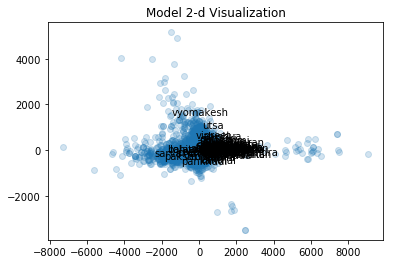

In [34]:
visualizePCA1(twoT2GramTextFS,trainNames)

#### Analysis:
* Word2Vec here is giving more dense cluster of names than last approach of one hot encoding
* This maybe because here we have used the context of each token
* This looks better!

* Creating oneClassSVM object using poly kernel
* Since here we have feature set that is dense so maybe poly kernel will be a better fit than linear
* First we will plot the learning curve

In [35]:
polySVM22Model=OneClassSVM(kernel='poly')

* Plotting Learning Curve for the 2token 2gram model

In [ ]:
plotLearningCurve(polySVM22Model,"Polynomial Kernel One SVM",twoT2GramTextFS,y,1,"accuracy")

In [36]:
testData=testNames+testFilesCorpus

In [37]:
y1=[1 for _ in testNames]
y2=[-1 for _ in testFilesCorpus]
testDataTarget=y1+y2
print(testData[:5],y[:5],testData[-5:],y[-5:])

['apparajito', 'aprameya', 'apratihat', 'apratim', 'apremeya'] [1, 1, 1, 1, 1] ['Zulfah', 'Zumzum', 'Zunairah', 'Zynah', 'Zyva'] [1, 1, 1, 1, 1]


In [38]:
#Get the Feature set that represents the test Data
testDataFS=getVectorsOfNames(twoT2GramObj.tokenSize,testData,token2Vec2Gram)
testDataFS=getFeatureSet(testDataFS)

In [ ]:
polySVM22Model.fit(twoT2GramTextFS)
testError1=polySVM.predict(testDataFS)
confusion_matrix(testDataTarget,testError1)

* Ran this for whole night but still couldnt finish training

#### Analysis:

### Check tokenSize=2 and 3Grams for context 

#### Intuition:
* Maybe creating more context for each token of the name can give us more information for each name
* This will help us catch more sequence structure of names

C:\Users\Siddharth\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


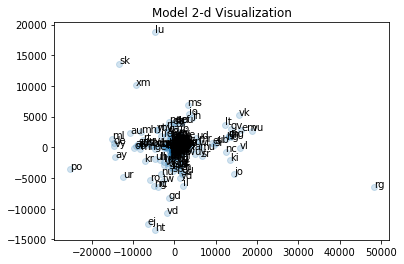

In [39]:
#Create Text Class object using 2 as token size and 3 as ngram parameter
twoT3GramObj=text(trainNames,2,3)

#Get the word2Vec model of tokens and generate the mapping dictionary
twoT3GramModel=formWord2Vec(twoT3GramObj.data,100,5)
token2Vec23=generateMapping(twoT3GramModel)

#Create Feature set of TrainNames
twoT3GramText=getVectorsOfNames(twoT3GramObj.tokenSize,trainNames,token2Vec23)
twoT3GramVectors=twoT3GramModel.wv.vectors

#Visualizing USing 2component PCA
visualizePCA(twoT3GramModel)

In [40]:
#Get the Feature Set of the trainNames in the twoT2GramModel
twoT3GramTextFS=getFeatureSet(twoT3GramText)

#Creating Target for test Corpus
y1=[1 for _ in testNames]
y2=[-1 for _ in testFilesCorpus]
testDataTarget=y1+y2
print(testData[:5],y[:5],testData[-5:],y[-5:])

['apparajito', 'aprameya', 'apratihat', 'apratim', 'apremeya'] [1, 1, 1, 1, 1] ['Zulfah', 'Zumzum', 'Zunairah', 'Zynah', 'Zyva'] [1, 1, 1, 1, 1]


In [41]:
#Get the Feature set that represents the test Data
testData23FS=getVectorsOfNames(twoT3GramObj.tokenSize,testData,token2Vec23)
testData23FS=getFeatureSet(testDataFS)

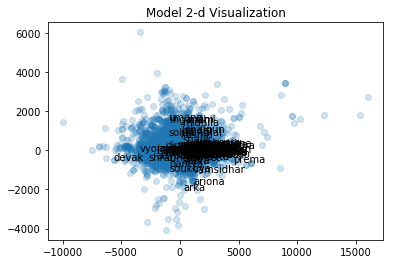

In [42]:
visualizePCA1(twoT3GramTextFS,trainNames)

In [ ]:
polySVM23Model.fit(twoT3GramTextFS)
testError2=polySVM.predict(testData23FS)
confusion_matrix(testDataTarget,testError2)

#### Trying out 3 token 2gram approach

In [43]:
#Make object of text class
threeToken2GramObj=text(totalNames,3,2)

In [44]:
#form word2 vec model
threeToken2GramM=formWord2Vec(threeToken2GramObj.data,100,5)

C:\Users\Siddharth\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


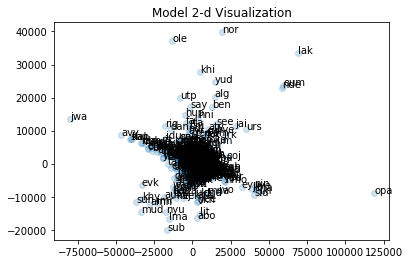

In [45]:
visualizePCA(threeToken2GramM)

#### Analysis:
* Strong similarity between most tokens
* Some tokens are quite dissimilar to others

In [46]:
#Generate mapping from token to vector
tToken2Gram2Vec=generateMapping(threeToken2GramM)

In [47]:
#Generate mean vectors to represent each name
tToken2GramText=getVectorsOfNames(threeToken2GramObj.tokenSize,totalNames,tToken2Gram2Vec)

In [48]:
#get feature set of these names
tToken2GramFS=getFeatureSet(tToken2GramText)

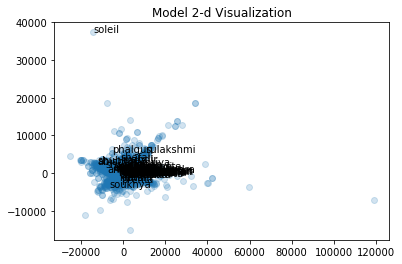

In [49]:
visualizePCA1(tToken2GramFS,totalNames)

In [98]:
tToken2GramFS.shape

(8190, 100)

<module 'matplotlib.pyplot' from 'C:\\Users\\Siddharth\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\matplotlib\\pyplot.py'>

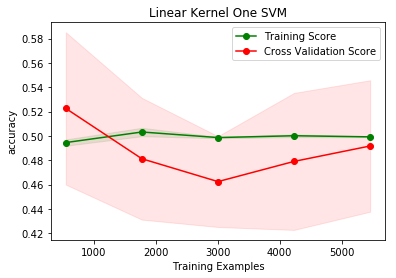

In [99]:
plotLearningCurve(linearSVM,"Linear Kernel One SVM",tToken2GramFS,y,1,"accuracy")

In [50]:
plt.show()

### Analysis:
* This approach is a testing ground for me
* This is a "Token2Vec" approach
* But this approach is very interesting as it tries to not only use the last approach but take the context of those tokens too
* This context can help us represent names better
* This context may also be a helpful way to learn the sequence structure 
* Word2Vec has gained much momemtum in the recent past and a very popular technique
* To form sentence representation out of token embeddings is also a research problem
* I have used average of each vector
* We can also use autoencoders to learn some latent representation of words
* We can train a classifer on these representation (like OneClassSVM) for one class classification